In [ ]:
# HIDE
%load_ext autoreload
%autoreload 2

In [1]:
# HIDE
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions


torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline

# Fairness in Machine Learning with PyTorch

Fairness is becoming a hot topic amongst machine learning researchers and practitioners. The field is aware that their models have a large impact on society and that the predictions they make are not always beneficial to all parties involved.
In a [previous blog](https://blog.godatadriven.com/fairness-in-ml), Stijn showed how adversarial networks can be used to make fairer predictions.
This blog post will focus more on the implementation part of things so that you as a practitioner are able to build your own fair classifiers.

Lets start with a short recap of how adversarial networks can help to battle unfairness.
Instead of having only a single classifier that makes predictions $\hat{y}$ with data $X$, we introduce an adversary that tries to predict if the classifier is unfair for the sensitive attributes $Z$.
The classifier has to compete with the adversary in a zero-sum game: the classifier has to make good predictions but is being penalized if the adversary detects unfair decisions.
The end-result of this game is, hopefully, a fair classifier that is also good at predicting.

<img src="images/architecture.png" alt="Architecture" width="750">

Instead of using keras and TensorFlow, we show how to use PyTorch to train the fair classifier.
I find PyTorch a bit nicer to try out new ideas, and switching frameworks keeps the mind sharp and the FOMO away!
Don't forget to read the [previous blog](https://blog.godatadriven.com/fairness-in-ml) so that you know why we're implementing these things.

In the next section, we start by loading the datasets with some PyTorch utilities.
After that, we will seperately define and pretrain the classifier and adversarial.
These components are then combined and trained together to give a fair classifier.

## Data

Our goal is to predict income levels based on personal attributes, such as age, education and marital status.
The problem is that our standard classifier is unfair to black people and women.
All other attributes being equal, women will, for instance, have lower income predictions than men - even though gender is not part of the personal attributes.
Biases like this can be specific to a dataset or even reflect the real world, but we don't want them to lead to unfair predictions.

We will start with our dataset from the previous blog.
We have the following pandas DataFrames:

- `X_train`, `X_test`: attributes used for prediction - like age and native country
- `y_train`, `y_test`: target we want to predict - if someone makes more than 50K
- `Z_train`, `Z_test`: sensitive attributes - race and color

In [2]:
# HIDE

# load ICU data set
X, y, Z = load_ICU_data('data/adult.data')

n_features = X.shape[1]
n_sensitive = Z.shape[1]

# split into train/test set
(X_train, X_test, y_train, y_test,
 Z_train, Z_test) = train_test_split(X, y, Z, test_size=0.5,
                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

features X: 30940 samples, 93 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


PyTorch has some [tools](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#) to make data loading and sampling easier.
Here, we will use the `Dataset` and `DataLoader`.
A `Dataset` represents your dataset and returns samples from it.
The `DataLoader` takes a `Dataset` and helps you with shuffling and batching your samples.

A `Dataset` generally takes and returns PyTorch tensors, not rows from a pandas DataFrame.
Let's add some logic to the [`TensorDataset`](https://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) that converts DataFrames into tensors.
Subclass the `TensorDataset` so we can initialize a `Dataset` with our pandas DataFrames:

In [3]:
class PandasDataSet(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train)
test_data = PandasDataSet(X_test, y_test, Z_test)

Create a `DataLoader` that returns shuffled batches of our training set:

In [4]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# training samples: 15470
# batches: 483


That is all the processing we need!
All the data needed for training and predicting are respectively in `train_loader` and `test_data`.
We get batches of data when iterating over the `train_loader`, `test_data` will be used to test our predictions.

## Income predictions

With our datasets in place, we define and pretrain the classifier to make income predictions.
This classifier will be good in predicting income level but is likely to be unfair - it is only penalized on performance and not on fairness.

The PyTorch's [`nn`](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module) module makes implementing a neural network easy.
We get a fully working network class by inheriting from `nn.Module` and implementing the `.forward()` method.
Our network consists of three sequential hidden layers with ReLu activation and dropout.
The sigmoid layer turns these activations into a probability for the income class.

In [5]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return F.sigmoid(self.network(x))

Initialize the classifier, choose binary cross entropy as the loss function and let Adam optimize the weights of the classifier:

In [6]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

Time to pretrain the classifier!
For each epoch, we iterate over the batches returned by our `DataLoader`.

In [7]:
# CHANGE

def pretrain_classifier(clf, data_loader, optimizer, criterion):
    for x, y, _ in data_loader:
        clf.zero_grad()
        p_y = clf(x)
        loss = criterion(p_y, y)
        loss.backward()
        optimizer.step()
    return clf


N_CLF_EPOCHS = 5

for epoch in range(N_CLF_EPOCHS):
    clf = pretrain_classifier(clf, train_loader, clf_optimizer, clf_criterion)

The above code does the following for each batch:
- Set the gradients relevant to our classifier to zero.
- Let the classifier `clf` predict for a batch `x` to give `p_y`.
- Compute the loss given the predictions and the real answer.
- Backpropagate the loss with a  `.backward()` to give the gradients to decrease the errors.
- Let the classifier optimizer perform an optimization step with these gradients.

The result should be a fairly performant though still unfair classifier.
We will check the performance after defining the adversary.

## Detecting unfairness

With the classifier pretrained, we now define and pretrain the adversarial.
Similar to the classifier, our adversarial consists of three layers.
However, the input comes from a single class (the predicted income class) and the output consists of two sensitive classes (sex and race).

For our final solution, there will be a trade-off between classifier performance and fairness for our sensitive attributes.
We will tweak the adversarial loss to incorporate that trade-off: the lambda parameter weighs the adversarial loss of each class.
This parameter is later also used to scale the adversarial performance versus the classifier performance.

By telling `nn.BCELoss` not to reduce we get the losses for each invididual sample and class instead of a single number.
Multiplying this with our `lambdas` and taking the average, gives us the weighted adversarial loss, our proxy for unfairness.

In [8]:
# CHANGE

class Adversarial(nn.Module):

    def __init__(self, n_sensitive, n_hidden=32):
        super(Adversarial, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_sensitive),
        )

    def forward(self, x):
        return F.sigmoid(self.network(x))


def pretrain_adversarial(adv, clf, data_loader, optimizer, criterion):
    for x, _, z in data_loader:
        p_y = clf(x).detach()
        adv.zero_grad()
        p_z = adv(p_y)
        loss = criterion(p_z, z)
        loss.backward()
        optimizer.step()
    return adv

adv = Adversarial(Z_train.shape[1])
adv_criterion = nn.BCELoss()
adv_optimizer = optim.Adam(adv.parameters())


N_ADV_EPOCHS = 5

for epoch in range(N_ADV_EPOCHS):
    pretrain_adversarial(adv, clf, train_loader, adv_optimizer, adv_criterion)

Training the adversary is pretty similar to how we trained the classifier.
Note that we [`.detach()`](https://pytorch.org/docs/master/autograd.html#torch.Tensor.detach) the predictions of the classifier from the graph.
This signals to PyTorch that we don't use the gradients of the classifier operations to optimize the adversary, allowing PyTorch to free up some memory.

Are our results similar to those of our earlier blog using keras and TensorFlow?
Pretty much!
The ROC AUC, accuracy and probability distributions look very similar.

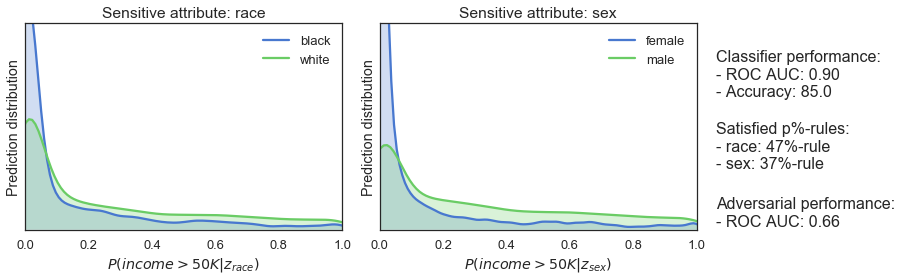

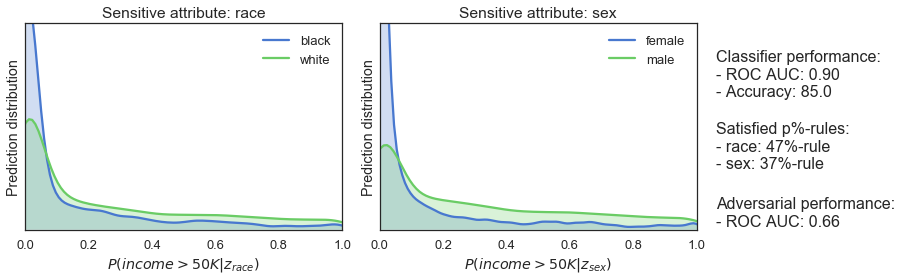

In [9]:
# HIDE

with torch.no_grad():
    pre_clf_test = clf(test_data.tensors[0])
    pre_adv_test = adv(pre_clf_test)


y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                      index=y_test.index)
y_pre_adv = pd.DataFrame(pre_adv_test.numpy(), columns=Z.columns)
fig = plot_distributions(y_test, Z_test, y_pre_clf, y_pre_adv)
fig

Unfortunately, switching frameworks did not magically make the classifier fairer.
We can see this from the probability p%-rule and distributions, but also from the ROC AUC score of the adversarial.
A score higher than 0.5 indicates that the adversarial is able to detect unfairness.

## Training for fairness

Now that we have an unfair classifier and an adversarial that is able to pick up on unfairness, we can engage them in the zero-sum game to make the classifier fair.
Remember that the fair classifier will be punished according to:

$$\min_{\theta_{clf}}\left[Loss_{y}(\theta_{clf})-\lambda Loss_{Z}(\theta_{clf},\theta_{adv})\right].$$

The first term represents how good the classifier is in predicting income, the second how good the adversary can reconstruct unfairness. 
The parameter $\lambda$ respresents the trade-off between these terms: it weighs the punishment by adverserial versus the prediction performance.

The adversary learns on the full data set and the classifier is given only the last batch, giving the adversary a slight edge in learning.
We need to retain the graph of the adversarial loss so we can use it to optimize the classifier.
The loss function for the classifier is changed to its original loss plus the weighted negative adversarial loss.

In [10]:
# HIDE
!rm -f output/torch_*.png

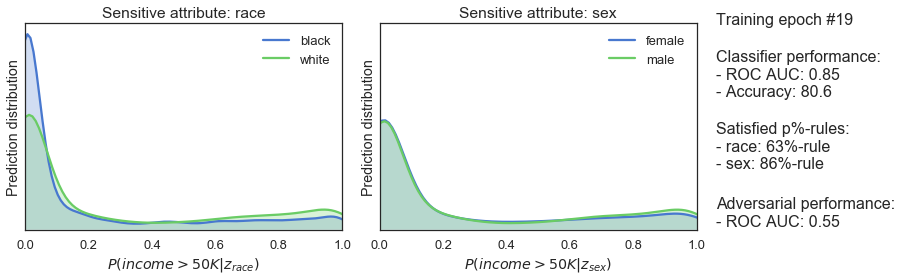

tensor(0.4546)
tensor(37.9436)
tensor(-37.4890)


KeyboardInterrupt: 

In [11]:
# CHANGE
train_loader_adv = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)
clf_criterion = nn.BCELoss(reduce=False)
clf_adv_criterion = nn.BCELoss(reduce=False)
lambdas = torch.Tensor([130.0, 30.0])
def train(clf, adv, data_loader, clf_criterion, adv_criterion,
          clf_optimizer, adv_optimizer, lambdas):
    clf_optimizer.zero_grad()
    adv_optimizer.zero_grad()
    for x, y, z in train_loader_adv:
        # Train adversarial
        clf.zero_grad()
        adv.zero_grad()
        for p in clf.parameters():
             p.requires_grad = False
        for p in adv.parameters():
             p.requires_grad = True
        p_y = clf(x)
        p_z = adv(p_y)
        loss_adv = adv_criterion(p_z, z)
        loss_adv.backward()
        adv_optimizer.step()
        
    # Train classifier on last batch
    x, y, z = list(train_loader_adv)[0]
    clf.zero_grad()
    adv.zero_grad()
    for p in clf.parameters():
         p.requires_grad = True
    for p in adv.parameters():
         p.requires_grad = False
    p_y = clf(x)
    p_z = adv(p_y)
    
    print(clf_criterion(p_y, y).mean())
    print((lambdas*adv_criterion(p_z, z)).mean())
    clf_loss = clf_criterion(p_y, y).mean() - (lambdas*adv_criterion(p_z, z)).mean()
    print(clf_loss)
    clf_loss.backward()
    clf_optimizer.step()
    
    
    return clf, adv

N_EPOCH_COMBINED = 165

for epoch in range(1, N_EPOCH_COMBINED):
    
    clf, adv = train(clf, adv, train_loader, clf_criterion, adv_criterion,
                     clf_optimizer, adv_optimizer, lambdas)

    with torch.no_grad():
        clf_pred = clf(test_data.tensors[0])
        adv_pred = adv(clf_pred)

    y_post_clf = pd.Series(clf_pred.numpy().ravel(), index=y_test.index)
    Z_post_adv = pd.DataFrame(adv_pred.numpy(), columns=Z_test.columns)
    
    fig = plot_distributions(y_test, Z_test, y_post_clf, Z_post_adv, epoch)
    display.clear_output(wait=True)
    plt.savefig(f'output/torch_{epoch+1:08d}.png', bbox_inches='tight')
    plt.show(plt.gcf())
    
last_img = f'output/torch_{epoch+1:08d}.png'

In [ ]:
# HIDE
!convert -loop 0 -delay 0 output/torch_*.png -delay 500 {last_img} images/torch_training.gif

Our results are pretty similar to our previous blog.
The classifier starts off unfair, but trades some of its performance for fairness.
At the end of training, the ROC AUC of the adversary is 0.50, indicating that it's unable to detect race or gender from the made predictions.
That's also shown by the p-rules: they're both above 80%.
We've succesfully used a adversarial neural network to make our classifier fair!

## Conclusion

This blog took you through the steps of implementing a fair classifier in PyTorch.
You can find the total and the original keras implementation in [our GitHub repo](https://github.com/equialgo/fairness-in-ml).
Please consider adding a Pull Request if you've succesfully applied this code to your dataset!